# Multi-Label Classification

Today we will be going over **multi-label** classification

First let's install our libraries

In [ ]:
#Run once per session
!pip install fastai -q --upgrade

Now let's grab what we need. For this particular one, we want `vision` and `data`

In [ ]:
from fastai.vision.all import *

For this multi-label problem, we will use the Planet dataset, where it's a collection of satellite images with multiple labels describing the scene. I'll go through and explain a few different ways to make this dataset, highlighting some of the flexibility the new `DataBlock` API can do. 

First, let's grab our data

In [ ]:
planet_source = untar_data(URLs.PLANET_SAMPLE)
df = pd.read_csv(planet_source/'labels.csv')

Now let's look at how it's stored. Our `DataFrame` is formatted so our images filename is the **first** column, and the labels in the **second**

In [ ]:
df.head()

,image_name,tags
0,train_21983,partly_cloudy primary
1,train_9516,clear cultivation primary water
2,train_12664,haze primary
3,train_36960,clear primary
4,train_5302,haze primary road


# Method 1 (DataBlock)

In [ ]:
batch_tfms = aug_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
planet = DataBlock(blocks=(ImageBlock, MultiCategoryBlock),
                   get_x=ColReader(0, pref=f'{planet_source}/train/', suff='.jpg'),
                   splitter=RandomSplitter(),
                   get_y=ColReader(1, label_delim=' '),
                   batch_tfms = batch_tfms)

* Multi-label so we want a `MultiCategoryBlock`
* `get_x` and `get_y` define how we expect to grab our data
* `ColReader` works with Pandas `DataFrames`

Now we can dataloaders by passing in our source folder

In [ ]:
dls = planet.dataloaders(df)

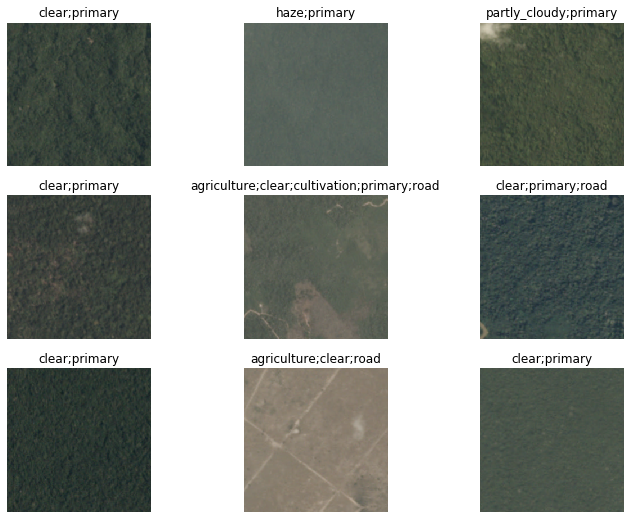

In [ ]:
dls.show_batch(max_n=9, figsize=(12,9))

# Method 2: `Lambda`'s

This next version will instead use `lambda` functions to grab our image names, which get's rid of the `ColReader`, if you're more familiar with these

In [ ]:
blocks = (ImageBlock, MultiCategoryBlock)

First let's try our `get_x`. Our lambda function needs to return a `Path()` to our particular image. This can be done by including `f'{x[0]}.jpg'` 

But what is that even doing? Let's take a look

In [ ]:
get_x = lambda x:planet_source/'train'/f'{x[0]}.jpg'

If we pass in one row of our `DataFrame`, we should expect to see the entire path laid out in front of us!

In [ ]:
val = df.values[0]; val

array(['train_21983', 'partly_cloudy primary'], dtype=object)

In [ ]:
get_x(df.values[0])

PosixPath('/root/.fastai/data/planet_sample/train/train_21983.jpg')

Which it does! A nice, simple, and *clean* way to grab our paths. Let's see how our `y` getter will look like

In [ ]:
get_y = lambda x:x[1].split(' ')

Looks fairly close to the previous version, if you pay attention. Remember that our `x` is the `DataFrame`'s values, so if we grab position 1 from earlier, we can see that it's our labels!

Let's make our full `PipeLine` now that we're sure everything will work

In [ ]:
planet = DataBlock(blocks=blocks,
                   get_x=get_x,
                   splitter=RandomSplitter(),
                   get_y=get_y,
                   batch_tfms=batch_tfms)

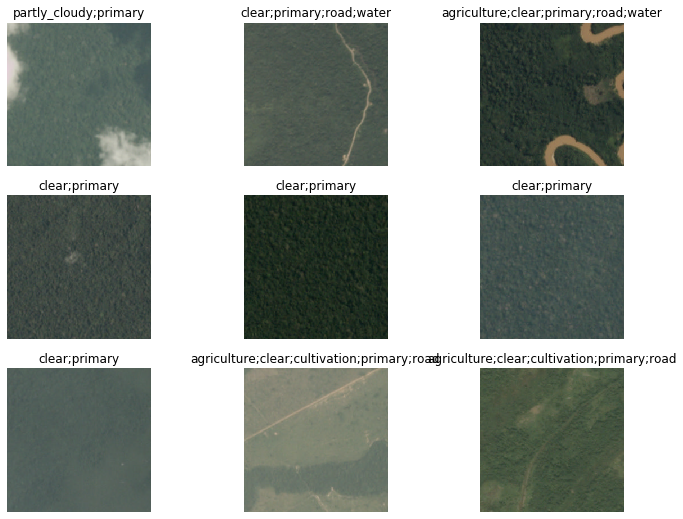

In [ ]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

# Method 3: Custom `get_items` Functions

That previous one worked fine, but shouldn't I be able to do a one-liner? Since it's all right there instead of defining our `get_x` and `get_y`? There *IS*! We can create our own function, where we should expect to return both an `x` and a `y` value. Let's make one 

In [ ]:
def _planet_items(x): return (
    f'{planet_source}/train/'+x.image_name+'.jpg', x.tags.str.split())

Our `DataBlock` now looks like so:

In [ ]:
planet = DataBlock.from_columns(blocks=(ImageBlock, MultiCategoryBlock),
                   get_items = _planet_items, 
                   splitter=RandomSplitter(),
                   batch_tfms=batch_tfms)

That's all our `DataBlock` needs if we can plan accordingly. Looks pretty clean!

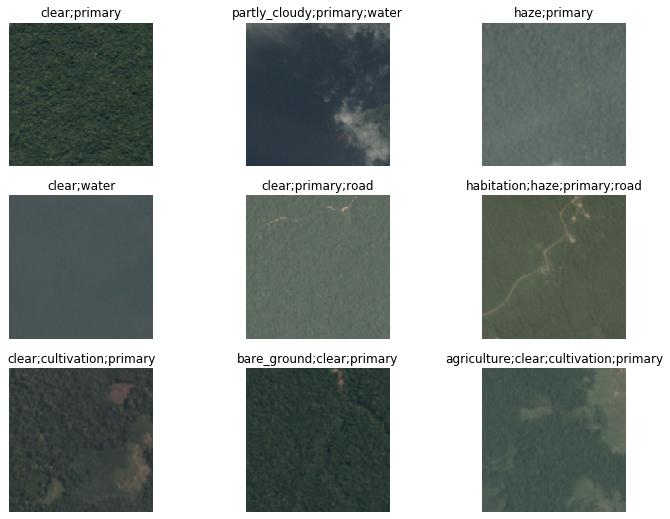

In [ ]:
dls = planet.dataloaders(df)
dls.show_batch(max_n=9, figsize=(12,9))

# Training a Model

We'll use a `resnet34` for this task

In [ ]:
from torchvision.models import resnet34

We'll use `accuracy_multi` for multi-classificaiton

In [ ]:
from fastai.metrics import accuracy_multi

In [ ]:
learn = cnn_learner(dls, resnet34, pretrained=True, metrics=[accuracy_multi])

Model results are on a scale with a threshold instead of exact, allows for "it's not any" due to a sigmoid activation in the loss function

In [ ]:
class BCEWithLogitsLossFlat(BaseLoss):
    "Same as `nn.CrossEntropyLoss`, but flattens input and target."
    def __init__(self, *args, axis=-1, floatify=True, thresh=0.5, **kwargs):
        super().__init__(nn.BCEWithLogitsLoss, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)
        self.thresh = thresh

    def decodes(self, x):    return x>self.thresh
    def activation(self, x): return torch.sigmoid(x)

In [ ]:
learn.loss_func = BCEWithLogitsLossFlat()

We'll find a good learning rate

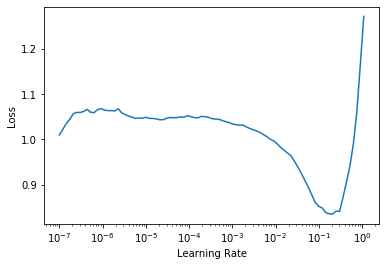

In [ ]:
learn.lr_find()

And train! (we'll also used mixed precision too!)

In [ ]:
lr = 1e-2
learn = learn.to_fp16()

In [ ]:
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.761724,0.320393,0.894412,00:14
1,0.366634,0.170998,0.940882,00:11
2,0.256233,0.149577,0.949118,00:11
3,0.199033,0.137296,0.949706,00:11
4,0.170974,0.136933,0.949706,00:11


Great! Let's save and `unfreeze` to train the rest of our model!

In [ ]:
learn.save('stage-1')

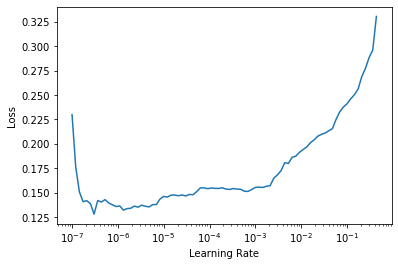

In [ ]:
learn.unfreeze()
learn.lr_find()

We can now go through and use a learning rate around 1e-5 or so, and then have an ending learning rate five times smaller than our starting

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.147181,0.146752,0.947353,00:15
1,0.153571,0.138148,0.953530,00:15
2,0.147831,0.129908,0.953530,00:15
3,0.127491,0.124736,0.956765,00:15
4,0.114531,0.126795,0.954118,00:15


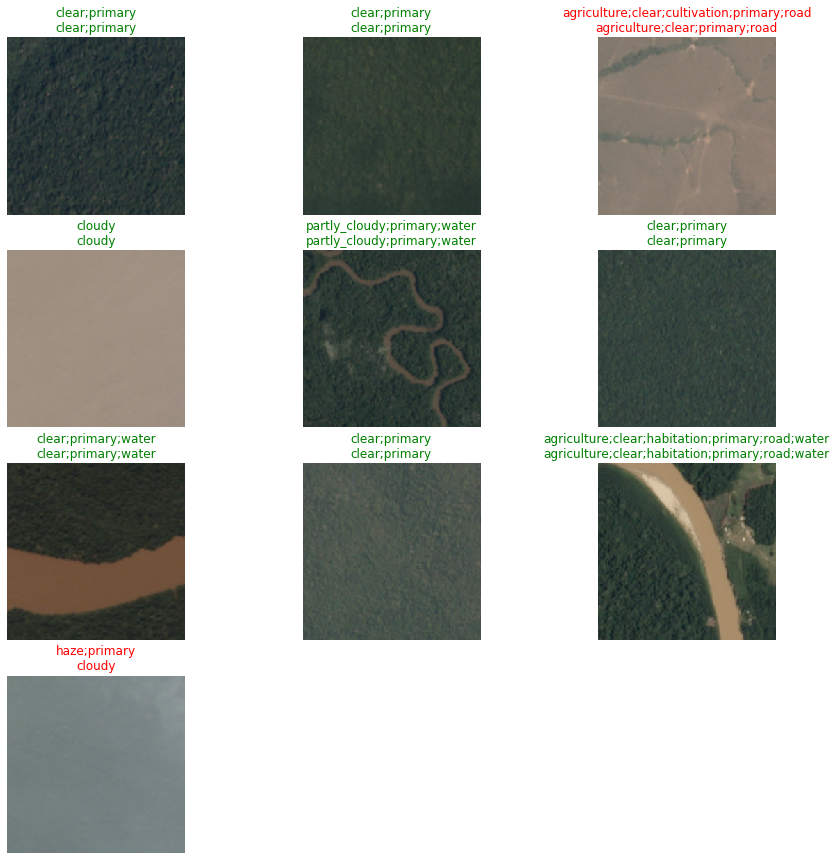

In [ ]:
learn.show_results(figsize=(15,15))